Company Map

What this process does:
* Loads & inspects cleaned apprenticeship and wage theft data
* Finds exact matches between contractor names
* Uses fuzzy matching to find similar but non-exact names
* Merges datasets to track contractors participating in both
* Analyzes relationships between apprenticeship participation & wage theft

## Load and Preview the Data
* This helps us determine which columns contain contractor names for matching.

In [3]:
import pandas as pd

# Load the datasets
df_apprentice = pd.read_csv("cleaned_construction_apprentice.csv")
df_wagetheft = pd.read_csv("cleaned_construction_wagetheft.csv")

# Preview the datasets
print("Apprenticeship Data Columns:", df_apprentice.columns.tolist())
print("Wage Theft Data Columns:", df_wagetheft.columns.tolist())

# Show sample data
print(df_apprentice.head())
print(df_wagetheft.head())


Apprenticeship Data Columns: ['sponsor', 'trade', 'signatory_name', 'signatory_address', 'city', 'state', 'zip_code', 'date_signatory_added', 'source']
Wage Theft Data Columns: ['ranking', 'company_name', 'industry', 'city', 'county', 'zip_code', 'date', 'claimants', 'wages_stolen']
                                            sponsor      trade  \
0  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
1  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
2  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
3  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
4  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   

                                     signatory_name  \
0                ADW CONSTRUCTION GROUP CORPORATION   
1                              AMBUILD SUPPLY, LLC.   
2                              AMBUILD SUPPLY, LLC.   
3  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE   
4                            CMI INSTALLATIO

## Check for Exact Matches

In [4]:
df_apprentice.columns

Index(['sponsor', 'trade', 'signatory_name', 'signatory_address', 'city',
       'state', 'zip_code', 'date_signatory_added', 'source'],
      dtype='object')

In [5]:
df_wagetheft.columns

Index(['ranking', 'company_name', 'industry', 'city', 'county', 'zip_code',
       'date', 'claimants', 'wages_stolen'],
      dtype='object')

In [6]:
# Convert contractor names to lowercase for standardization
df_apprentice["signatory_name"] = df_apprentice["signatory_name"].str.lower().str.strip()
df_wagetheft["company_name"] = df_wagetheft["company_name"].str.lower().str.strip()

# Find exact matches
common_names = set(df_apprentice["signatory_name"]) & set(df_wagetheft["company_name"])
print(f"Found {len(common_names)} exact matches between apprenticeships and wage theft datasets.")


Found 49 exact matches between apprenticeships and wage theft datasets.


## Apply Fuzzy Matching for Similar Names
* If exact matches are low, use fuzzy matching to find closely related names.

In [7]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.0 MB/s eta 0:00:00


In [8]:
from rapidfuzz import process, fuzz

# Convert names into lists
apprentice_names = df_apprentice["signatory_name"].dropna().unique()
wagetheft_names = df_wagetheft["company_name"].dropna().unique()

# Function for fuzzy matching
def fuzzy_match(name, choices, threshold=85):
    match = process.extractOne(name, choices, scorer=fuzz.partial_ratio, score_cutoff=threshold)
    return match[0] if match else None

# Apply fuzzy matching
df_apprentice["matched_wagetheft_name"] = df_apprentice["signatory_name"].apply(lambda x: fuzzy_match(x, wagetheft_names))

# Display results
print(df_apprentice[["signatory_name", "matched_wagetheft_name"]].head(10))


                                     signatory_name  \
0                adw construction group corporation   
1                              ambuild supply, llc.   
2                              ambuild supply, llc.   
3  associated builders and contractors empire state   
4                            cmi installations llc.   
5                           gallo construction corp   
6                               gec contracting inc   
7                                h & k services inc   
8                           loduca associates, inc.   
9                                  luck bros., inc.   

                     matched_wagetheft_name  
0                           md construction  
1                                 dc supply  
2                                 dc supply  
3                            ayj contractor  
4                 spring installation, llc.  
5          moisha drywall construction corp  
6  pc concrete pala perfect contracting inc  
7                         

## Merge Matched Contractors

In [9]:
# Merge on exact and fuzzy-matched names
df_merged = df_apprentice.merge(df_wagetheft, left_on="matched_wagetheft_name", right_on="company_name", how="left")

# Save merged dataset
df_merged.to_csv("merged_apprenticeship_wagetheft.csv", index=False)
print("Merged dataset saved!")

Merged dataset saved!


## Analyze the Data

* Find contractors who participated in apprenticeships but have wage theft records

* Find the most frequent violating contractors

In [10]:
violating_apprentices = df_merged[df_merged["matched_wagetheft_name"].notnull()]
print(f"{len(violating_apprentices)} contractors have both apprenticeships and wage theft violations.")

22931 contractors have both apprenticeships and wage theft violations.


In [11]:
top_violators = df_merged["matched_wagetheft_name"].value_counts().head(10)
print("Top 10 Contractors with Wage Theft Records:\n", top_violators)

Top 10 Contractors with Wage Theft Records:
 matched_wagetheft_name
ce construction            690
al construction            486
ters                       467
jmb corporation            394
uno construction           332
er construction            322
jr contracting             292
amr services inc           287
b construction services    274
mh construction            262
Name: count, dtype: int64


## Visualizing the Merged Apprenticeship & Wage Theft Data
* Visualizations to explore relationships between apprenticeship participation and wage theft violations.

In [12]:
# Preview the dataset
print(df_merged.head())

                                            sponsor      trade  \
0  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
1  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
2  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
3  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   
4  ASSOCIATED BUILDERS AND CONTRACTORS EMPIRE STATE  CARPENTER   

                                     signatory_name  \
0                adw construction group corporation   
1                              ambuild supply, llc.   
2                              ambuild supply, llc.   
3  associated builders and contractors empire state   
4                            cmi installations llc.   

             signatory_address         city_x state zip_code_x  \
0               46 CHESHIRE RD       BETHPAGE    NY      11714   
1  6605 PITTSFORD PALMYRA ROAD       FAIRPORT    NY      14450   
2  6605 PITTSFORD PALMYRA ROAD       FAIRPORT    NY      14450   
3       

### Count How Many Contractors Have Wage Theft Violations

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

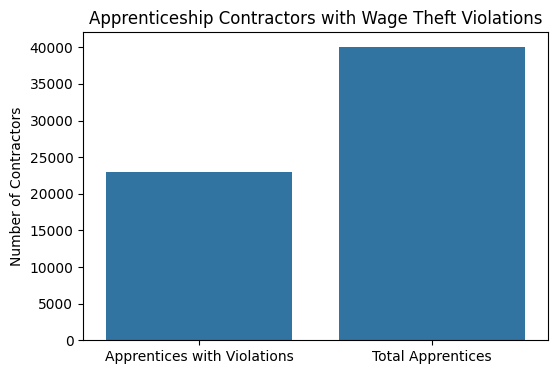

In [14]:
# Count the number of contractors with wage theft violations
violating_apprentices = df_merged["matched_wagetheft_name"].notnull().sum()
total_apprentices = df_merged.shape[0]

# Create a bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=["Apprentices with Violations", "Total Apprentices"], y=[violating_apprentices, total_apprentices])
plt.ylabel("Number of Contractors")
plt.title("Apprenticeship Contractors with Wage Theft Violations")
plt.show()

* This shows how widespread wage theft is among apprenticeship contractors.

###  Top 10 Contractors with the Most Wage Theft Cases

<ipython-input-15-554795cab508>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_violators.index, x=top_violators.values, palette="Reds_r")


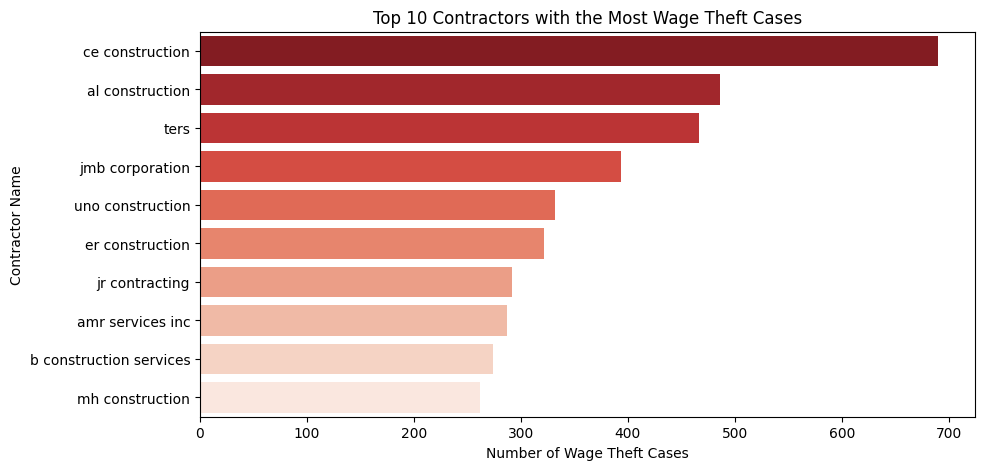

In [15]:
# Count wage theft cases by contractor
top_violators = df_merged["matched_wagetheft_name"].value_counts().head(10)

# Plot the top 10 violators
plt.figure(figsize=(10, 5))
sns.barplot(y=top_violators.index, x=top_violators.values, palette="Reds_r")
plt.xlabel("Number of Wage Theft Cases")
plt.ylabel("Contractor Name")
plt.title("Top 10 Contractors with the Most Wage Theft Cases")
plt.show()

* This highlights the worst offenders in the dataset.

In [16]:
df_merged.columns

Index(['sponsor', 'trade', 'signatory_name', 'signatory_address', 'city_x',
       'state', 'zip_code_x', 'date_signatory_added', 'source',
       'matched_wagetheft_name', 'ranking', 'company_name', 'industry',
       'city_y', 'county', 'zip_code_y', 'date', 'claimants', 'wages_stolen'],
      dtype='object')

### Fix City Column Duplicates

In [17]:
import numpy as np

# Fill missing cities in city_x with city_y
df_merged["city"] = np.where(df_merged["city_x"].notna(), df_merged["city_x"], df_merged["city_y"])

# Drop old city columns
df_merged.drop(columns=["city_x", "city_y"], inplace=True)

print("Fixed duplicate city columns. Using 'city' for visualizations.")


Fixed duplicate city columns. Using 'city' for visualizations.


In [18]:
# Drop exact duplicate rows
df_merged.drop_duplicates(inplace=True)

# Drop duplicates based on company name & city
df_merged.drop_duplicates(subset=["signatory_name", "city"], keep="first", inplace=True)

print(f"Removed duplicate rows. Dataset now has {df_merged.shape[0]} unique records.")

Removed duplicate rows. Dataset now has 14658 unique records.


In [19]:
missing_cities = df_merged["city"].isna().sum()
print(f"{missing_cities} records are missing a city name.")

1 records are missing a city name.


<ipython-input-20-249bd3b92d7f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=city_violations.index, x=city_violations.values, palette="Blues_r")


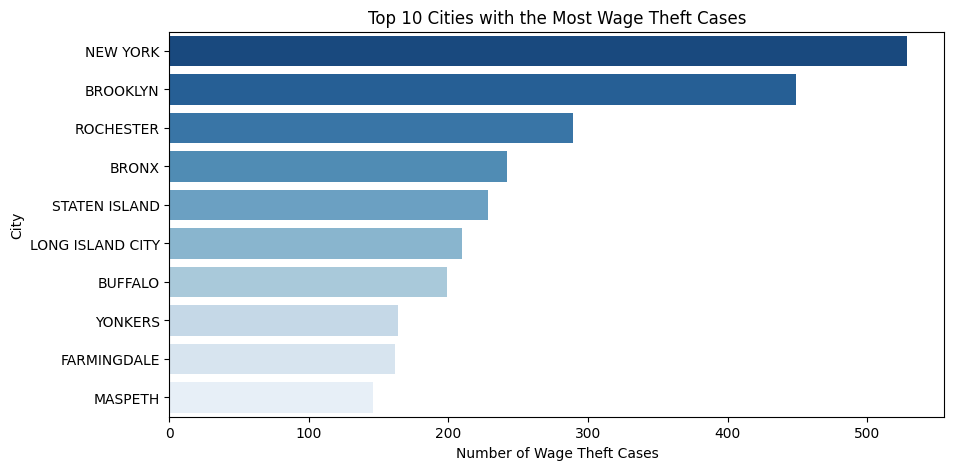

In [20]:
# Count cases per city
city_violations = df_merged["city"].value_counts().head(10)

# Plot city-wise wage theft counts
plt.figure(figsize=(10, 5))
sns.barplot(y=city_violations.index, x=city_violations.values, palette="Blues_r")
plt.xlabel("Number of Wage Theft Cases")
plt.ylabel("City")
plt.title("Top 10 Cities with the Most Wage Theft Cases")
plt.show()


* This helps NYFFC understand which areas have the worst wage violations.

## Next Steps

* Confirm fuzzy matching results (check for incorrect matches).
* Merge with additional datasets (e.g., Checkbook NYC or Debarment List).
* Create visualizations (charts showing top violators, comparisons, trends).

## Stream Lit ID

In [21]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00


In [22]:
!pip install streamlit ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:00


In [24]:
df_merged.columns

Index(['sponsor', 'trade', 'signatory_name', 'signatory_address', 'state',
       'zip_code_x', 'date_signatory_added', 'source',
       'matched_wagetheft_name', 'ranking', 'company_name', 'industry',
       'county', 'zip_code_y', 'date', 'claimants', 'wages_stolen', 'city'],
      dtype='object')

In [25]:
df_wagetheft.columns


Index(['ranking', 'company_name', 'industry', 'city', 'county', 'zip_code',
       'date', 'claimants', 'wages_stolen'],
      dtype='object')

In [26]:
df_apprentice.columns


Index(['sponsor', 'trade', 'signatory_name', 'signatory_address', 'city',
       'state', 'zip_code', 'date_signatory_added', 'source',
       'matched_wagetheft_name'],
      dtype='object')

In [28]:
import streamlit as st
import pandas as pd

# Load updated datasets
df_apprentice = pd.read_csv("cleaned_construction_apprentice.csv")
df_wagetheft = pd.read_csv("cleaned_construction_wagetheft.csv")
#df_checkbook = pd.read_csv("updated_checkbook.csv")


In [29]:
%%writefile app.py
import streamlit as st
import pandas as pd

# Load datasets
df_apprentice = pd.read_csv("cleaned_construction_apprentice.csv")
df_wagetheft = pd.read_csv("cleaned_construction_wagetheft.csv")
#df_checkbook = pd.read_csv("updated_checkbook.csv")

# Merge all datasets
df_combined = pd.concat([df_apprentice, df_wagetheft])

# Streamlit App UI
st.title("NYFFC Contractor Search Tool")

# User input for search
search_query = st.text_input("Enter a Company Name or Address:")

if search_query:
    results = df_combined[
        (df_combined["signatory_name"].str.contains(search_query, case=False, na=False)) |
        (df_combined["trade"].str.contains(search_query, case=False, na=False)) |
        (df_combined["company_name"].str.contains(search_query, case=False, na=False)) |
        (df_combined["signatory_address"].str.contains(search_query, case=False, na=False))
    ]

    if not results.empty:
        st.write("### Matching Contractors")
        st.dataframe(results)
    else:
        st.write("No matching contractors found.")


Writing app.py


In [30]:
!streamlit run app.py &>/dev/null &


In [31]:
!pip install pyngrok
from pyngrok import ngrok

# Replace "YOUR_NGROK_AUTH_TOKEN" with your actual token
ngrok.set_auth_token("2U8F5zr5gSunlSRMoivQMp8NmCY_7PnHFmTMTNSSj3gyjv9rL")


In [32]:
# Start the ngrok tunnel
public_url = ngrok.connect(8501, "http")
print(f"Streamlit App Running at: {public_url}")


Streamlit App Running at: NgrokTunnel: "https://dfa4-34-125-215-246.ngrok-free.app" -> "http://localhost:8501"


In [34]:
df_merged['signatory_address'].value_counts()

,count
signatory_address,
150 MEADOWLANDS PARKWAY,19
UNKNOWN,18
31 GARDEN LANE,18
43-06 54TH ROAD,17
1750 NEW HIGHWAY,16
...,...
415 A MEACHAN AVE,1
80 VERDI ST SUITE B,1
3838 13TH STREET,1


## NYFFC Contractor Search Tool
https://7fcf-34-75-217-23.ngrok-free.app/


In [36]:
import streamlit as st
import pandas as pd

# Streamlit App UI
st.title("NYFFC Contractor Search Tool")
st.write("Enter a company name or address to find matching records.")

# User input for search
search_query = st.text_input("Search for Contractor Name or Address:")

if search_query:
    search_columns = ["signatory_name", "trade_name", "contractor_name", "company_name", "signatory_address", "city", "state", "zip_code", "industry", "wages_stolen", "debarment_status"]
    valid_columns = [col for col in search_columns if col in df_combined.columns]

    # Apply search query
    search_condition = df_merged[valid_columns].apply(lambda x: x.astype(str).str.contains(search_query, case=False, na=False)).any(axis=1)
    results = df_merged[search_condition]

    if not results.empty:
        st.write("### Matching Contractors")

        # Show relevant details in a clean format
        selected_columns = ["contractor_name", "signatory_name", "trade_name", "signatory_address", "city", "state", "zip_code", "industry", "wages_stolen", "debarment_status"]
        selected_columns = [col for col in selected_columns if col in results.columns]  # Ensure columns exist

        st.dataframe(results[selected_columns])
    else:
        st.write("No matching contractors found.")


2025-03-17 21:34:45.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.055 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:45.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [37]:
# Start the ngrok tunnel
public_url = ngrok.connect(8501, "http")
print(f"Updated Streamlit App Running at: {public_url}")

Updated Streamlit App Running at: NgrokTunnel: "https://c284-34-125-215-246.ngrok-free.app" -> "http://localhost:8501"


### Add a "Download Report" Button

In [38]:
import streamlit as st
import pandas as pd


st.title("NYFFC Contractor Search Tool")
search_query = st.text_input("Search for Contractor Name or Address:")

if search_query:
    # Define relevant columns for searching
    search_columns = ["contractor_name", "signatory_name", "trade_name", "signatory_address", "city", "state", "zip_code", "industry", "wages_stolen", "debarment_status"]
    valid_columns = [col for col in search_columns if col in df_combined.columns]

    # Apply search query
    search_condition = df_combined[valid_columns].apply(lambda x: x.astype(str).str.contains(search_query, case=False, na=False)).any(axis=1)
    results = df_combined[search_condition]

    if not results.empty:
        st.write("### Matching Contractors")

        # Select which columns to display
        selected_columns = ["contractor_name", "signatory_name", "trade_name", "signatory_address", "city", "state", "zip_code", "industry", "wages_stolen", "debarment_status"]
        selected_columns = [col for col in selected_columns if col in results.columns]

        st.dataframe(results[selected_columns])

        # **Add a Download Button for Reports**
        st.download_button(
            label="📥 Download Report (CSV)",
            data=results[selected_columns].to_csv(index=False).encode("utf-8"),
            file_name="nyffc_contractor_report.csv",
            mime="text/csv",
        )

        st.download_button(
            label="📥 Download Report (Excel)",
            data=results[selected_columns].to_excel(index=False, engine="openpyxl"),
            file_name="nyffc_contractor_report.xlsx",
            mime="application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
        )

    else:
        st.write("No matching contractors found.")


2025-03-17 21:34:52.587 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.590 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:52.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

### Add Links to Contractor Histories

In [39]:
import streamlit as st
import pandas as pd


st.title("NYFFC Contractor Search Tool")
search_query = st.text_input("Search for Contractor Name or Address:")

# Ensure results always exist
results = pd.DataFrame()  # Initialize empty results dataframe

if search_query:
    # Define relevant columns for searching
    search_columns = ["contractor_name", "signatory_name", "trade_name", "signatory_address", "city", "state", "zip_code", "industry", "wages_stolen", "debarment_status"]
    valid_columns = [col for col in search_columns if col in df_combined.columns]

    # Apply search query
    search_condition = df_combined[valid_columns].apply(lambda x: x.astype(str).str.contains(search_query, case=False, na=False)).any(axis=1)
    results = df_combined[search_condition]

    if not results.empty:
        # Create a column for clickable links to contractor history
        results["Contractor Profile"] = results["contractor_name"].apply(lambda x: f"[🔍 View Details](?contractor={x.replace(' ', '%20')})")

        # Display updated dataframe with clickable links
        st.write("### Matching Contractors")
        st.dataframe(results[["contractor_name", "trade_name", "city", "state", "wages_stolen", "debarment_status", "Contractor Profile"]])

        # **🚀 Add a Download Button for Reports**
        st.download_button(
            label="📥 Download Report (CSV)",
            data=results.to_csv(index=False).encode("utf-8"),
            file_name="nyffc_contractor_report.csv",
            mime="text/csv",
        )

    else:
        st.write("No matching contractors found.")


2025-03-17 21:34:55.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 21:34:55.611 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [40]:
# Create a column for clickable links to contractor history
results["Contractor Profile"] = results["contractor_name"].apply(lambda x: f"[🔍 View Details](?contractor={x.replace(' ', '%20')})")

# Display updated dataframe with clickable links
st.write("### Matching Contractors")
st.dataframe(results[["contractor_name", "trade_name", "city", "state", "wages_stolen", "debarment_status", "Contractor Profile"]])


KeyError: 'contractor_name'

In [ ]:
if "contractor" in st.query_params:
    contractor_name = st.query_params["contractor"]
    contractor_details = df_combined[df_combined["contractor_name"] == contractor_name]

    if not contractor_details.empty:
        st.write(f"## Details for {contractor_name}")
        st.write(contractor_details)
    else:
        st.write("No additional details available.")
